# Instance Segmentation

Here we aim to create a model for instance segmentation<br><br>
**Tested environment for Tensorflow-GPU:**<br>
python = 3.7.x (3.7.16)<br>
tensorflow-gpu = 2.5.0<br>
cudatoolkit = 11.3.1<br>
cudnn = 8.2.1<br>


In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `tf.keras` framework.


In [2]:
sm.set_framework('tf.keras')
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #Hide GPU to train on CPU

Now we load the image data

In [3]:
# loading image data...
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

We need to define the image and mask datasets

In [4]:
# Define datasets
print("Defining image dataset...")
image_dataset = data_loader("../images/") # Real images
print("Defining mask dataset...")
mask_dataset = data_loader("../label_images/") # Masked images
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print(mask_dataset.shape)

Defining image dataset...


Defining mask dataset...
(400, 128, 128, 3)


To check everything was done correctly, we show a random image, with its corresponding mask

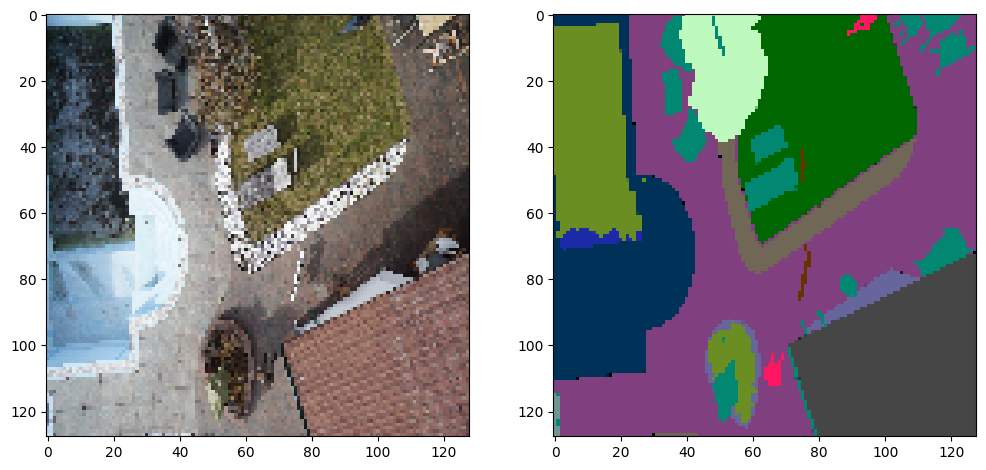

In [5]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

Now we need to get the mask labels along with their RGB values, and print them out for ease of reading

In [6]:
mask_labels = pd.read_csv('../data/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv') # mask labels RGB values...
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


Next up we need to read the 3 RGB values and match them with the correct label

In [7]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dim...

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


Now we need to check that the above code worked correctly, so we show an image along with the label

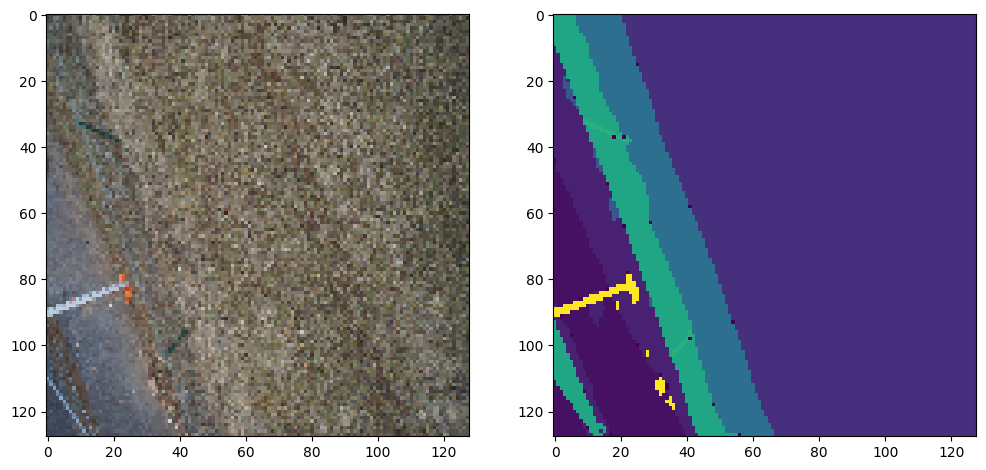

In [8]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...

# Creating the model
Now we can move onto working on the model, for this task we will be using UNet and have ResNet34 as the backbone for the model, along with its preprocessed input. We will grab all the ImageNet weights and use that as the starting point prior to training. We use the Adam optimizer, and because we have multiple classes, we use the SoftMax activation function, along with categorical crossentropy as the loss function.

Step #1 is to split the dataset into train and test splits, in this case, 80% of the dataset will be used for training, and 20% used for testing.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

In [10]:
# Using weights from the pretrained ResNet model
BACKBONE = 'resnet34' 
# Define preprocessing input
preprocess_input = sm.get_preprocessing(BACKBONE)

# Splitting the preprocessed input to its corresponding split
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# Defining the model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# Use accuracy as the metric, set the optimizer and loss
metrics=['accuracy']
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics) #maybe use jaccard loss?

# Show the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

To have some sort of backup incase anything goes wrong with training, here we define the callbacks, we have checkpoints that overwrite the model ONLY IF the current checkpoint has a higher accuracy. If we go through 5 epochs with no increase in accuracy, we call an early stop.

In [11]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs
#checkpoint = ModelCheckpoint(filepath="../models/segmentation_model.h5", verbose=2, save_best_only=True)

# EarlyStopping callback is used to stop the training when accuracy doesn't improve for 5 epochs
#early_stop = EarlyStopping(monitor="accuracy", min_delta=0, patience=5)

#callbacks = [checkpoint, early_stop]

#tf.test.gpu_device_name()

Now that we have everything in place, we can start fitting the model.

In [1]:
# Training the model for 100 epochs with batch size of 16
history = model.fit(X_train_prepr, 
          y_train,
          batch_size=8, 
          epochs=100,
          #callbacks=callbacks,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

NameError: name 'model' is not defined

To monitor the model as it trains, we need to plot the metrics.

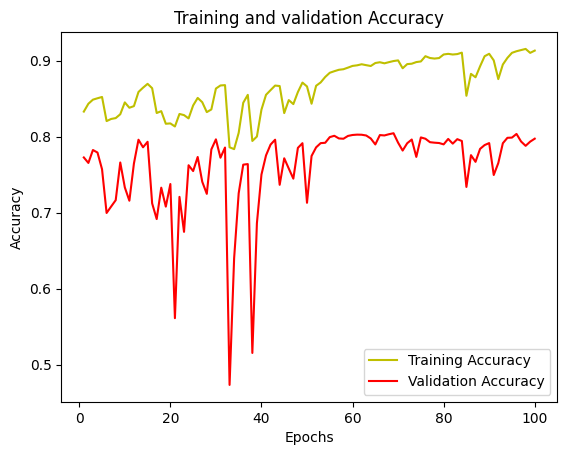

In [ ]:
# Plotting train and val accuracy in each epoch
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Save the model after training is finished

In [ ]:
model.save('../models/segmentation_model_256.hdf5')

Load the saved model for testing

In [ ]:
model = load_model('../models/segmentation_model_256.hdf5')

Now we can make predictions, for this we grab a random image from the test split, and its corresponding mask, and we plot it against the model prediction.

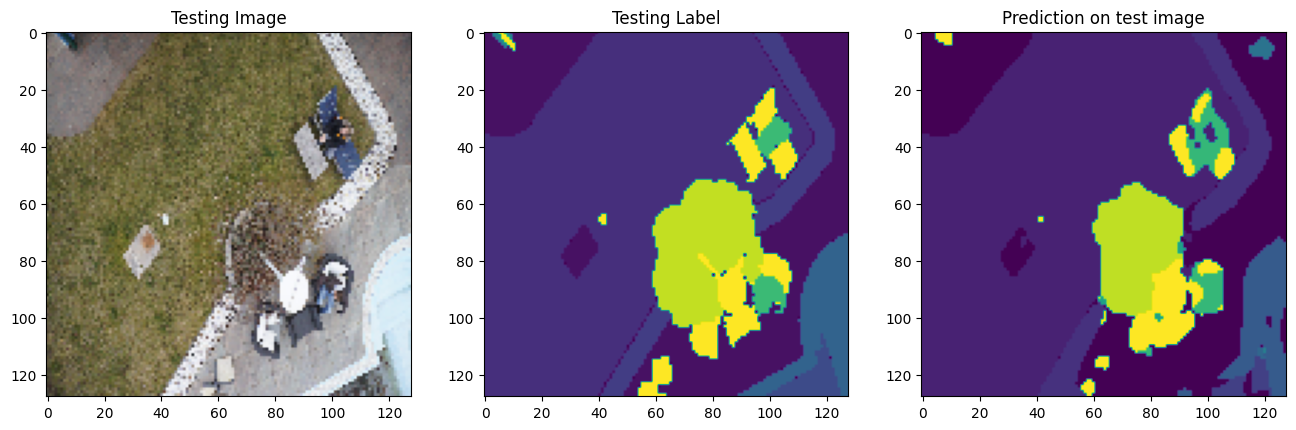

In [ ]:
# Making predictions
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

# Randomly selecting an image from the test set and making prediction
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

# Plotting the real image, its mask, and its predicted mask
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()